In [2]:
import pandas as pd
import numpy as np
df = pd.read_excel("df.xlsx")
df.head()

,sex,year_of_diagnosis,race,age,marital_status,AJCC_Stage,AJCC_T,AJCC_N,AJCC_M,surgery,radiation,chemotherapy,tumor_size,primary_site,stage,surviva_months,status
0,Female,2004,White,8,no,IIA,T1,N0,M0,yes,yes,yes,64,"C40.0-Long bones: upper limb, scapula, and ass...",Regional,192,0
1,Male,2004,White,12,no,IIB,T2,N0,M0,no,yes,yes,170,"C41.4-Pelvic bones, sacrum, coccyx and associa...",Regional,72,1
2,Male,2004,White,14,no,IVB,T2,N0,M1b,no,yes,yes,95,"C41.4-Pelvic bones, sacrum, coccyx and associa...",Distant,166,0
3,Female,2008,White,49,no,IIA,T1,N0,M0,yes,yes,yes,35,"C41.3-Rib, sternum, clavicle and associated jo...",Regional,153,0
4,Male,2004,White,45,no,IVA,T2,N0,M1a,yes,no,yes,120,C40.2-Long bones of lower limb and associated ...,Distant,7,1


In [65]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 4.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=54485e4f6d74339ba3a6d33147613e99a8fc1c3adc1addca3422060c9b9598aa
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


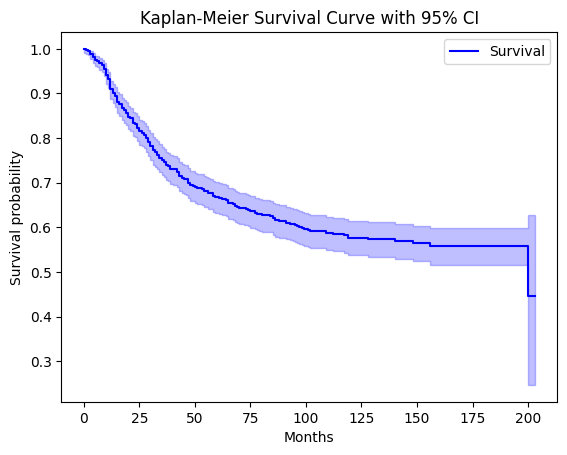

In [66]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
# Columns in your df: 'surviva_months' for time, 'status' for event (1=event, 0=censored)
T = df['surviva_months']
E = df['status']

# Initialize KM fitter
kmf = KaplanMeierFitter()

# Fit the data
kmf.fit(T, event_observed=E, label='Survival')

# Plot KM curve with 95% confidence interval
ax = kmf.plot(ci_show=True, color='blue')
ax.set_xlabel('Months')
ax.set_ylabel('Survival probability')
ax.set_title('Kaplan-Meier Survival Curve with 95% CI')
plt.show()

In [3]:

# Define time points in months
time_points = [12, 36, 60]  # 1, 3, 5 years
# Create binary labels: 1 if patient died before the time point, 0 otherwise
for t in time_points:
    df[f"status_{t}m"] = np.where((df["status"] == 1) & (df["surviva_months"] <= t), 1, 0)


In [36]:
# Drop original survival info from features
X = df.drop(columns=["surviva_months", "status", "status_12m", "status_36m", "status_60m"])

# One-hot encode categorical variables
X_enc = pd.get_dummies(X, drop_first=True)

# Optional: scale numerical columns
from sklearn.preprocessing import StandardScaler

num_cols = ["age", "year_of_diagnosis", "tumor_size"]
scaler = StandardScaler()
X_enc[num_cols] = scaler.fit_transform(X_enc[num_cols])
import numpy as np

# Convert to numeric type
X_enc_num = X_enc.astype(float)

# Check for inf values
np.isinf(X_enc_num).sum()  # should be 0

# Optionally replace any remaining NaN or inf
X_enc_num = np.nan_to_num(X_enc_num, nan=0.0, posinf=1e10, neginf=-1e10)


In [149]:
from sklearn.model_selection import train_test_split

# Example: predicting 1-year survival
y = df["status_60m"]  # change to status_36m or status_60m for other times

X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.2, random_state=42, stratify=y
)


/tmp/ipython-input-1970634809.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette=['skyblue','salmon'])


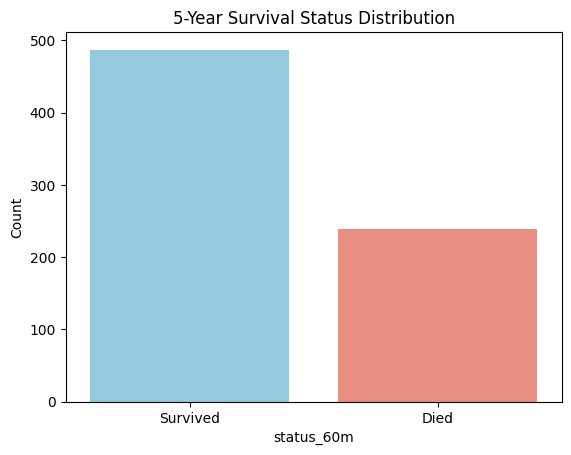

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=y, palette=['skyblue','salmon'])
plt.xticks([0,1], ['Survived', 'Died'])
plt.ylabel("Count")
plt.title("5-Year Survival Status Distribution")
plt.show()

In [44]:
from sklearn.utils import resample

# Combine X and y temporarily
train_data = X_train.copy()
train_data['target'] = y_train

# Separate majority and minority classes
majority = train_data[train_data.target == 0]
minority = train_data[train_data.target == 1]

# Downsample majority
majority_downsampled = resample(
    majority,
    replace=False,    # sample without replacement
    n_samples=len(minority), # match minority count
    random_state=42
)

# Combine minority and downsampled majority
train_balanced = pd.concat([majority_downsampled, minority])

# Shuffle
train_balanced = train_balanced.sample(frac=1, random_state=42)

# Separate X and y again
X_train_balanced = train_balanced.drop('target', axis=1)
y_train_balanced = train_balanced['target']



In [45]:
import numpy as np
import pandas as pd

# Assuming X_train_balanced is a DataFrame or array
# For a pandas DataFrame
print("NaNs in X_train_balanced:\n", X_train_balanced.isna().sum())
print("Any NaNs in X_train_balanced:", X_train_balanced.isna().any().any())

print("NaNs in y_train_balanced:", pd.Series(y_train_balanced).isna().sum())



NaNs in X_train_balanced:
 year_of_diagnosis                                                            0
age                                                                          0
tumor_size                                                                   0
sex_Male                                                                     0
race_Other (American Indian/AK Native, Asian/Pacific Islander)               0
race_White                                                                   0
marital_status_yes                                                           0
AJCC_Stage_IIB                                                               0
AJCC_Stage_III                                                               0
AJCC_Stage_IV                                                                0
AJCC_Stage_IVA                                                               0
AJCC_Stage_IVB                                                               0
AJCC_T_T2                

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Drop any row with NaN in features or target
X_enc_clean = X_enc.dropna()
y_clean = y.loc[X_enc_clean.index]  # make sure y matches


rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
lr_model = LogisticRegression(max_iter=1000)
dt_model = DecisionTreeClassifier(random_state=42)
svm_model = SVC(probability=True, random_state=42)

rf_model.fit(X_train_balanced, y_train_balanced)
dt_model.fit(X_train_balanced, y_train_balanced)
svm_model.fit(X_train_balanced, y_train_balanced)
lr_model.fit(X_train_balanced, y_train_balanced)






LogisticRegression(max_iter=1000)

In [51]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# Example: evaluate a fitted model on the test set
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # probability of class 1

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (PPV)": precision_score(y_test, y_pred),
        "Recall (Sensitivity)": recall_score(y_test, y_pred),
        "Specificity": tn / (tn + fp + 1e-10),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    }
    return results

# Example usage
eval_rf = evaluate_model(svm_model, X_test, y_test)
print(eval_rf)


{'Accuracy': 0.815068493150685, 'Precision (PPV)': 0.28125, 'Recall (Sensitivity)': 0.6923076923076923, 'Specificity': np.float64(0.8270676691723106), 'F1-score': 0.4, 'ROC-AUC': np.float64(0.7270098322729902)}


In [54]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split first
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original class distribution:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_smote.value_counts())
rf_model.fit(X_train_smote, y_train_smote)
dt_model.fit(X_train_smote, y_train_smote)
svm_model.fit(X_train_smote, y_train_smote)
lr_model.fit(X_train_smote, y_train_smote)
eval_rf = evaluate_model(svm_model, X_test, y_test)
print(eval_rf)



Original class distribution:
 status_12m
0    528
1     52
Name: count, dtype: int64
After SMOTE:
 status_12m
0    528
1    528
Name: count, dtype: int64
{'Accuracy': 0.8767123287671232, 'Precision (PPV)': 0.2727272727272727, 'Recall (Sensitivity)': 0.23076923076923078, 'Specificity': np.float64(0.9398496240594438), 'F1-score': 0.25, 'ROC-AUC': np.float64(0.6604973973395026)}


In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Example: Random Forest with class weights
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Example: SVM with class weights
svm_model = SVC(class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Decision Tree
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [56]:
eval_rf = evaluate_model(svm_model, X_test, y_test)
print(eval_rf)


{'Accuracy': 0.8493150684931506, 'Precision (PPV)': 0.2631578947368421, 'Recall (Sensitivity)': 0.38461538461538464, 'Specificity': np.float64(0.8947368421045905), 'F1-score': 0.3125, 'ROC-AUC': np.float64(0.7189126662810874)}


In [150]:
from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
])


scoring = ['accuracy', 'f1', 'roc_auc', 'precision_macro', 'recall_macro']

cv_results = cross_validate(
    pipeline,
    X_train,
    y_train,
    cv=5,
    scoring=scoring
)

print("Mean accuracy:", cv_results['test_accuracy'].mean())
print("Mean precision:", cv_results['test_precision_macro'].mean())
print("Mean F1:", cv_results['test_f1'].mean())
print("Mean ROC-AUC:", cv_results['test_roc_auc'].mean())
print("Mean recall:", cv_results['test_recall_macro'].mean())


Mean accuracy: 0.646551724137931
Mean precision: 0.6148795942846352
Mean F1: 0.5079709000161989
Mean ROC-AUC: 0.6234195628932471
Mean recall: 0.6234195628932471


In [151]:
from sklearn.model_selection import cross_validate
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Define a pipeline with downsampling + classifier
pipeline = Pipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

# Metrics to evaluate
scoring = ['accuracy', 'f1', 'roc_auc', 'precision_macro', 'recall_macro']

# Run cross-validation
cv_results = cross_validate(
    pipeline,
    X_train,
    y_train,
    cv=5,
    scoring=scoring
)

# Print mean metrics
print("Mean accuracy:", cv_results['test_accuracy'].mean())
print("Mean precision:", cv_results['test_precision_macro'].mean())
print("Mean ROC-AUC:", cv_results['test_roc_auc'].mean())
print("Mean recall:", cv_results['test_recall_macro'].mean())
print("Mean F1:", cv_results['test_f1'].mean())


Mean accuracy: 0.5844827586206897
Mean precision: 0.5818526168425362
Mean ROC-AUC: 0.5916925180083075
Mean recall: 0.5916925180083075
Mean F1: 0.4928808265441928


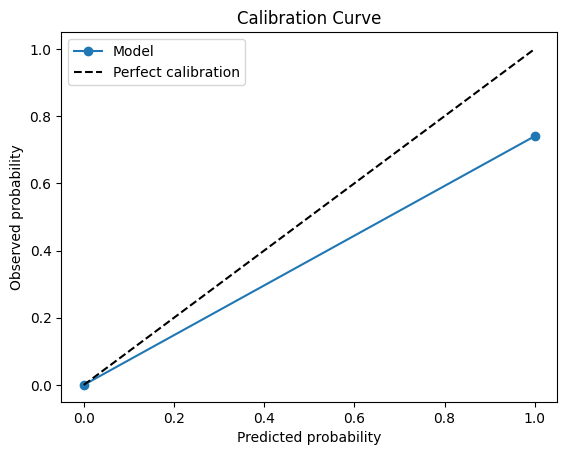

In [152]:
from sklearn.calibration import calibration_curve

y_prob_full = pipeline.fit(X_train, y_train).predict_proba(X_train)[:, 1]
prob_true, prob_pred = calibration_curve(y_train, y_prob_full, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0,1],[0,1], 'k--', label='Perfect calibration')
plt.xlabel('Predicted probability')
plt.ylabel('Observed probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()



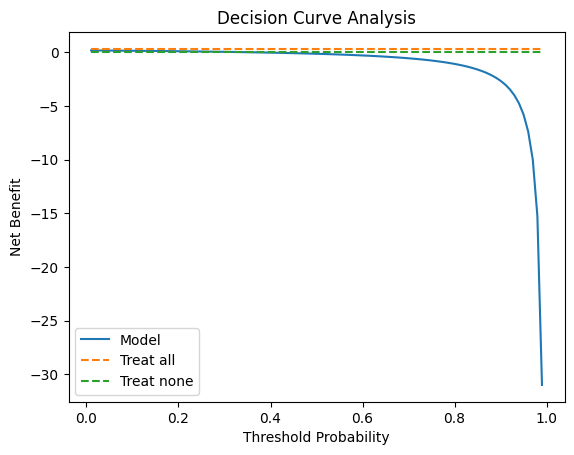

In [153]:
import numpy as np
import matplotlib.pyplot as plt

def net_benefit(y_true, y_prob, thresholds):
    nb = []
    for t in thresholds:
        preds = (y_prob >= t).astype(int)
        tp = ((preds==1) & (y_true==1)).sum()
        fp = ((preds==1) & (y_true==0)).sum()
        n = len(y_true)
        nb.append((tp/n) - (fp/n)*(t/(1-t)))
    return nb

thresholds = np.linspace(0.01, 0.99, 99)
y_prob = pipeline.predict_proba(X_test)[:,1]

nb_model = net_benefit(y_test.values, y_prob, thresholds)
nb_all = [sum(y_test==1)/len(y_test)]*len(thresholds)  # treat-all strategy
nb_none = [0]*len(thresholds)  # treat-none strategy

plt.plot(thresholds, nb_model, label='Model')
plt.plot(thresholds, nb_all, '--', label='Treat all')
plt.plot(thresholds, nb_none, '--', label='Treat none')
plt.xlabel('Threshold Probability')
plt.ylabel('Net Benefit')
plt.title('Decision Curve Analysis')
plt.legend()
plt.show()

